In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import keras
import cv2

In [ ]:
def get_train_length(dataset, batch_size, test_percent):
    # substract test_percent to be excluded from training, reserved for testset
    length = dataset
    length *= 1 - test_percent
    train_length_values = []
    for x in range(int(length) - 100,int(length)): 
        modulo=x%batch_size
        if (modulo == 0):
            train_length_values.append(x)
            print (x)
    return (max(train_length_values))

In [ ]:
from distutils.version import LooseVersion
from collections import OrderedDict
import cv2
import fnmatch
from PIL import Image
from copy import deepcopy
from scipy.misc import imresize
import re

class DataLoader():
    def __init__(self, seq_length = None,shuffle=True, augment=None, start=0, step = 1, frag_len = 50):
        self.seq_length = seq_length
        self.step = 1
        #self.Xs = []
        #self.ys = []
        self.augment = augment
        self.frames = []
        self.labels = []
        self.start = start
        self.step = step
        self.frag_len = frag_len
        
        #print("Number of elements: \n")
        #print(self.nb_elements)
    
    def _add_frame(self, i, frame):
        """
        frame : image frame to append to image sequence
        """ 
        frame = self._resizer(frame,(256,400))
        self.frames.append(frame)
            
    def _add_labels(self, i, label_img):
        """
        label_img : segmentation frame to append to segmentation sequence
        """ 
        _cls = imresize(label_img,(400,256))
        self.labels.append(_cls)

    def _resizer(self, data, dimso):
        """
        data : the image to be resized 
        dimso : the dimensions to be resized to (tuple)
        """
        data = cv2.resize(data, dimso)
        return data
    
    def _sequence_segmenter(self,sequence, frag_len, step):
        """
        sequence[list of lists]: the image sequence
        frag_len[int]: how long each fragment length will be or number of repeated LSTM units. divisible by sequnce length
        step[int]: steps taken between frames
        """
        samples = [sequence[i:i + frag_len] for i in range(0, len(sequence), frag_len)]
        return samples


    def load_data(self,file_name):
         # Store sample
        input_dir, input_n = os.path.split(file_name)
        input_name, ext = os.path.splitext(input_n)
        if ext not in ('.avi', '.mp4', '.tif'):
            raise IOError('Format %s not supported' % (ext))
        
        # Find matching label file
        label_file = None
        for f in os.listdir(input_dir):
            if fnmatch.fnmatch(f, input_name  + '.label.tif'):
                label_file = f
                break

        # Read multi-page label tif using PIL
        if label_file is None:
            print(input_name + '' + '.label.tif' + ' Not found')
            raise IOError('Label file not found')    
        
    
        # Read video in frame by frame as list of lists
        if ext in ('.avi', '.mp4'):
            print("Processing an avi file...")
            video = cv2.VideoCapture(file_name)
            if LooseVersion(cv2.__version__) < LooseVersion('3'):
                num_frames = int(video.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
            else:
                num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            print("Number of frames in that sample " + str(num_frames))
            
            for i in range(num_frames):
                is_valid, img = video.read()
                if not is_valid:
                    print('Cannot read frame: %d of %s' % (i, file_name))
                    num_frames = i + 1
                    break
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                self._add_frame(i, img)
        else:  # TIFF
            seq = Image.open(file_name)
            num_frames = seq.n_frames
            print(n_frames)
            for i in range(self.start, seq.n_frames, self.step):
                seq.seek(i)
                a = np.array(seq.convert('L'))
                self._add_frame(i, a)
            

        # Read matching label file frame by frame as list of lists
        labels = Image.open(os.path.join(input_dir, label_file))
        self.label_file_fullpath = os.path.join(input_dir, label_file)
        self.label_file = label_file
        self.labels_tag = deepcopy(labels.tag)
        self.nb_classes = 0
        for i in range(self.start, num_frames, self.step):
            labels.seek(i)
            cls = np.array(labels)
            self.nb_classes = max(self.nb_classes, np.max(cls) + 1)
            # Read 'verified' tag in first frame
            if i == 0:
                try:
                    self.verified = read_verified_tag(labels.tag)
                except:
                    pass
               
            self._add_labels(i, cls)
        
        # fetch sequences
        X = self.frames
        y = np.expand_dims(self.labels[0], axis = 0)
        y = np.expand_dims(y, axis = 0)
        
        
        #now we split the sequences into sequence fragments
        X_fragmented = self._sequence_segmenter(X, self.frag_len, self.step)
        #y_fragmented = self._sequence_segmenter(y, self.frag_len, self.step)
        
        
        X = np.array(X_fragmented)
        y = np.array(y)
            
        return X, y
    
    def load_dummy(self,file_name):
         # Store sample
        input_dir, input_n = os.path.split(file_name)
        input_name, ext = os.path.splitext(input_n)
        
        # Find matching label file
        label_file = None
        data_num = int(re.search(r'\d+', input_name).group())    
        # Read video in frame by frame as list of lists
        
            
        
        # fetch sequences
        X_loaded = np.load(file_name)
        y_loaded = np.load(input_dir+'/label_' + str(data_num) + '.npy')
        
        X = np.array([imresize(image.reshape(256,400), (128,200)) for image in X_loaded])
        y = np.array([imresize(image.reshape(256,400), (128,200)) for image in y_loaded])

        #y = stats.threshold(imresize(y,(1,64,100,1)),threshmin=0, threshmax=1, newval=-1) 
        #X.imresize(22, 64, 100,1)
        #y.imresize(1, 64, 100, 1)
        
        
        #now we split the sequences into sequence fragments
        #X_fragmented = self._sequence_segmenter(X, self.frag_len, self.step)
        #y_fragmented = self._sequence_segmenter(y, self.frag_len, self.step)
        
        
        #X = np.array(X_fragmented)
        #y = np.array(y)
            
        return X, y

In [358]:
X = np.load('dummies/video_0.npy')
y = np.load('dummies/label_0.npy')
print(X.shape, y.shape)
X.resize(22, 128, 200,1)
y.resize(1, 128, 200, 1)
print(X.shape, y.shape)

(22, 256, 400, 1) (1, 256, 400, 1)
(22, 128, 200, 1) (1, 128, 200, 1)


In [ ]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,list_IDs, batch_size=1, dim=(500,512,512,1), n_channels=1,
                 n_classes=10, shuffle=True, dummy=False):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
        self.dummy = dummy
        print("Generator Initiated")

    def __len__(self):
        'number of iterations per epoch. value (rounded up) obtained by dividing the number of samples by the batch size'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # The batch size determines how many IDs get fed into here
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        #print("Number of IDs " + str(len(list_IDs_temp)))
        
        X = []
        y = []
        
        if self.dummy is True:
        #do this
            #print("Dummy Generator Called")
            for i, ID in enumerate(list_IDs_temp):
                #print("Id being processed " + ID)
                data_loader = DataLoader()
                X_out, y_out = data_loader.load_dummy(ID)
                X.append(X_out)
                y.append(y_out)
                
            X = np.expand_dims(X, axis = -1)
            y = np.expand_dims(y, axis = -1)
            
            #X = np.array(X)
            #y = np.array(y)
            
        else:
            # Generate data
            print("This Shit Real")
            for i, ID in enumerate(list_IDs_temp):
                #print("Id being processed " + ID)
                data_loader = DataLoader()
                X_out, y_out = data_loader.load_data(ID)

                X = np.expand_dims(X_out, axis = -1)
                y = np.expand_dims(y_out, axis = -1)

        #print(X.shape)
        #print(y.shape)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples can also do preprocessing here' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size, *self.dim, self.n_channels))

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             X,y_ = load_data (list_IDs_temp)

#         return X, y
    

# Stateful vs Stateless LSTMs for Dummy Data

So this notebook was supposed to contain the data generators which feed data to the network.However, I dont know what this data structure uis expected to be yet because I am not completely sure whether to use stateful or not. So we will do both. And we will first do it for a dummy data just to see

## STATELESS

So in the stateless case, the inner states of the memory cells and the oupts of these memory cells are initiated to zero everytime a sample is sent through the network

## STATEFUL

In the stateful case we can "reserve the state" this is so that the inner memory and the oupputs are saved after each smaple is fed through the network to iniatiate the state of the network in the next round for the next sample. This is useful for example in the case that a long sequence is broken up into multiple shorter sequences but the sequences still contain temporally dpendant information.

Data generators are important when we have too much data. In this way we can feed batches of the data to the network at a time without having to load the entire data set into memory. There are two ways of making data generators. One way is the classical python generator and the other way is through inheriting the Sequence calss from keras. We have chosenn the latter. Sequences in this way are a safer way to do multiprocessing. This structure guarantees that the network will only train once on each sample per epoch which is not the case with generators.

## Stateless LSTM: no datareshape

Model instantiation

NOTE: STATELESS=FALSE in  ConvLSTM2D layers

In [360]:
from keras.models import Model
from keras.layers.convolutional import Conv3D, Conv2D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, TimeDistributed
import keras.backend as K
import tensorflow as tf

K.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(device_count = {'GPU': 0})))

input_shape = (None, 128, 200, 1)
input = Input(input_shape, name='input')

x = ConvLSTM2D(filters=14, kernel_size=(3, 3),
                   input_shape=input_shape,
                   padding='same', 
                   return_sequences=True)(input)
x = BatchNormalization()(x)
x = TimeDistributed(Conv2D(filters=2, kernel_size=(3,3), padding='same',activation='relu'))(x)
output = TimeDistributed(Conv2D(filters=1, kernel_size=(1,1), padding='same', activation='sigmoid'), name='output')(x)
# output = Conv3D(filters=1, kernel_size=(3, 3, 3),
#                    activation='sigmoid',
#                    padding='same', data_format='channels_last')(x)


model_stateless = Model(inputs = [input], output=[output])
model_stateless.compile(loss='binary_crossentropy', optimizer='adadelta')
model_stateless.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, None, 128, 200, 1) 0         
_________________________________________________________________
conv_lst_m2d_10 (ConvLSTM2D) (None, None, 128, 200, 14 7616      
_________________________________________________________________
batch_normalization_10 (Batc (None, None, 128, 200, 14 56        
_________________________________________________________________
time_distributed_9 (TimeDist (None, None, 128, 200, 2) 254       
_________________________________________________________________
output (TimeDistributed)     (None, None, 128, 200, 1) 3         
Total params: 7,929
Trainable params: 7,901
Non-trainable params: 28
_________________________________________________________________


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


Create data generators with dummy data for stateless LSTM

NOTE: DUMMY IS SET TO TRUE

In [ ]:
import numpy as np
import os

from keras.models import Sequential

# # Parameters
params = {'dim': (500,256,400),
          'batch_size': 8,
          'n_channels': 1,
          'n_classes': 0,
          'shuffle': False,
          'dummy':True}


input_dir = os.path.expanduser('~/Documents/ConvLSTM/dummies/')


# Datasets
partition = {}
labels = {}



nb_samples = 128
batch_size = 16
test_percent = 0.1
train_range = get_train_length(nb_samples, batch_size, test_percent)

train_IDs = [input_dir + 'video_' + str(i) + '.npy' for i in range(train_range)]
valid_IDs = [input_dir + 'video_'+str(i)+'.npy' for i in range(train_range+1,nb_samples+1)]


partition['train'] = train_IDs
partition['validation'] = valid_IDs

# Generators
training_generator = DataGenerator(partition['train'], **params)
validation_generator = DataGenerator(partition['validation'], **params)

"""
steps_per_epoch: Integer. Total number of steps (batches of samples) to 
yield from generator before declaring one epoch finished and starting the 
next epoch. It should typically be equal to the number of samples of your 
dataset divided by the batch size. Optional for  Sequence: if unspecified, 
will use the len(generator) as a number of steps."""

In [362]:
import math
steps_per_epoch = int(math.floor(len(train_IDs)/batch_size))
validation_steps = int(math.floor(len(valid_IDs)/batch_size))
steps_per_epoch,validation_steps,len(train_IDs), len(valid_IDs)

(7, 1, 112, 16)

In [ ]:
# Train model on dataset
#  steps_per_epoch: It should typically be equal to the number of samples of your dataset divided by the batch size
#                   Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch.
#  epochs: An epoch is an iteration over the entire data provided, as defined by  steps_per_epoch
#          model is not trained for a number of iterations given by epochs but merely until the epoch of index epochs is reached

steps_per_epoch = len(train_IDs)/batch_size
validation_steps = len(valid_IDs)/batch_size
model_stateless.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs = 5,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = validation_steps,
                    use_multiprocessing=True,
                    workers=10)
# When there are many workers, the do everything in parallel doing many samples at the same time

In [ ]:
model_stateless.save_weights('model_weights0p6110.h5')
model_stateless.save('first_model.h5')

In [143]:
predict_ids = [input_dir + 'video_' + str(i) + '.npy' for i in range(200,201)]
print(len(predict_ids))
for item in predict_ids:
    print(item)
predictor_generator = DataGenerator(predict_ids, **params)

1
/home/pelonomi/Documents/ConvLSTM/dummies/video_200.npy
Generator Initiated


In [332]:
X_loaded = np.load("dummies/video_200.npy")
y_loaded = np.load("dummies/label_200.npy")

X = np.array([imresize(image.reshape(256,400), (128,200)) for image in X_loaded])
y = np.array([imresize(image.reshape(256,400), (128,200)) for image in y_loaded])
X.shape, y.shape

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


((22, 128, 200), (1, 128, 200))

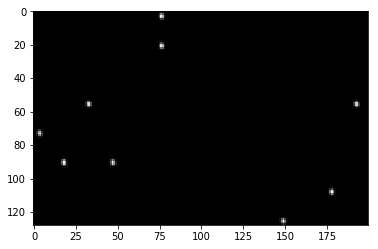

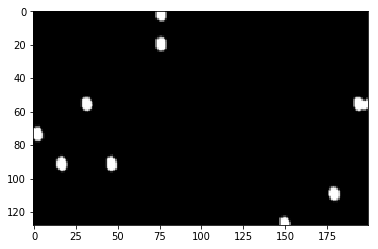

((22, 128, 200, 1), (1, 128, 200, 1))

In [349]:
X_out = np.expand_dims(X, axis = -1)
y_out = np.expand_dims(y, axis = -1)


plt.imshow(X[16], cmap = 'gray')
plt.show()
plt.imshow(y[0], cmap = 'gray')
plt.show()
X_out.shape, y_out.shape

(22, 128, 200)


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


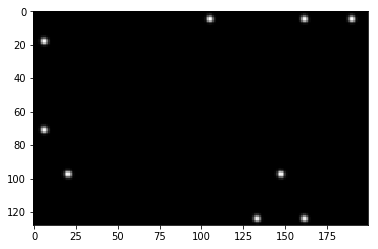

In [307]:
test = np.load("dummies/video_202.npy")
truth = np.array([imresize(image.reshape(256,400), (128,200)) for image in test])
print(truth.shape)
plt.imshow(truth[11], cmap = 'gray')
plt.show()

(1, 256, 400, 1)


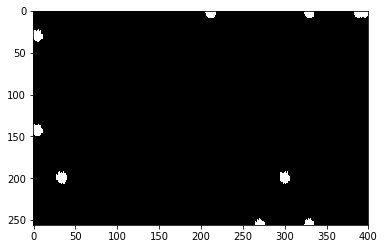

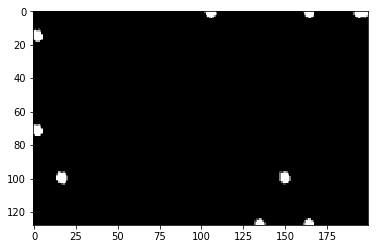

/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/ipykernel_launcher.py:14: DeprecationWarning: `threshold` is deprecated!
stats.threshold is deprecated in scipy 0.17.0
  


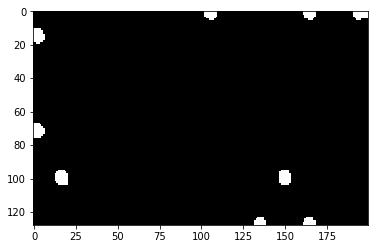

ValueError: cannot resize this array: it does not own its data

In [238]:
predict = stateless_answers[0].reshape(22,128,200)
from scipy import stats

vect = np.load("dummies/label_202.npy")
print(vect.shape)
truth = vect[0].reshape(256,400)
plt.imshow(truth, cmap = 'gray')
plt.show()
# resizing image with cv2
video = cv2.resize(truth,(200,128))
plt.imshow(video, cmap = 'gray')
plt.show()
# resizing image with scipy imsize
video = stats.threshold(imresize(truth,(128,200)),threshmin=0, threshmax=1, newval=-1) 
plt.imshow(video, cmap = 'gray')
plt.show()
# resizing image with numpy resize
vect = np.load("dummies/label_202.npy")
truth = vect[0]
truth.resize(1,128,200,1)
truth[0].reshape(128,200)
plt.imshow(video, cmap = 'gray')
plt.show()

Sateful LSTM

In [ ]:
#From https://www.reddit.com/r/MachineLearning/comments/4k3i2n/keras_stateful_lstm_what_am_i_missing/
#Logic goes like this

BatchSize = 5
sequences = [ X[I::BatchSize] for I in xrange(BatchSize) ]
batches   = [ sequences[:, N] for N in xrange(X.shape[0]/BatchSize) ]
# sequences[0] == [0, 5, 10, …]
# sequences[1] == [1, 6, 11, …]
# sequences[2] == [2, 7, 12, …]
# sequences[3] == [3, 8, 13, …]
# sequences[4] == [4, 9, 14, …]

# batches[0] == [ 0,  1,  2,  3,  4]
# batches[1] == [ 5,  6,  7,  8,  9]
# batches[2] == [10, 11, 12, 13, 14]

# Stateful vs Stateless for Neurofinder data

Note: Dummy is set to false

In [27]:
import numpy as np
import os

from keras.models import Sequential

# # Parameters
params = {'dim': (500,256,400),
          'batch_size': ,
          'n_channels': 1,
          'n_classes': 0,
          'shuffle': True,
          'dummy':False}


input_dir = os.path.expanduser('~/Documents/ConvLSTM/Databinary/')


# Datasets
partition = {}
labels = {}

partition['train'] = [input_dir + 'substack500_7fps_00.avi',input_dir + 'substack500_7fps_01.avi']
labels['train'] = [input_dir + 'substack500_7fps_00_label.tif',input_dir + 'substack500_7fps_01_label.tif']
partition['validation'] = [input_dir + 'substack500_7fps_02.avi']
labels['validation'] = [input_dir + 'substack500_7fps_02_label.tif']

# Generators
training_generator = DataGenerator(partition['train'], labels, **params)
validation_generator = DataGenerator(partition['validation'], labels, **params)

"""
steps_per_epoch: Integer. Total number of steps (batches of samples) to 
yield from generator before declaring one epoch finished and starting the 
next epoch. It should typically be equal to the number of samples of your 
dataset divided by the batch size. Optional for  Sequence: if unspecified, 
will use the len(generator) as a number of steps."""


Generator Initiated
Generator Initiated


'\nsteps_per_epoch: Integer. Total number of steps (batches of samples) to \nyield from generator before declaring one epoch finished and starting the \nnext epoch. It should typically be equal to the number of samples of your \ndataset divided by the batch size. Optional for  Sequence: if unspecified, \nwill use the len(generator) as a number of steps.'

In [28]:
# Train model on dataset
model.fit_generator(generator=training_generator,
                    #validation_data=validation_generator,
                    steps_per_epoch = 1,
                    validation_steps = 1,
                    use_multiprocessing=True,
                    workers=2)
# When there are many workers, the do everything in parallel doing many samples at the same time

Number of IDs 1
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_00.avi
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_01.avi
Processing an avi file...
Processing an avi file...
Number of frames in that sample 500
Number of frames in that sample 500
Epoch 1/1


/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/home/pelonomi/anaconda3/envs/tensorflowenv/lib/python3.5/site-packages/scipy/

(10, 50, 400, 256)
(1, 1, 400, 256)
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_01.avi
Processing an avi file...
Number of frames in that sample 500
(10, 50, 400, 256)
(1, 1, 400, 256)
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_00.avi
Processing an avi file...
Number of frames in that sample 500
(10, 50, 400, 256)
(1, 1, 400, 256)
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_01.avi
Processing an avi file...
Number of frames in that sample 500
(10, 50, 400, 256)
(1, 1, 400, 256)
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_00.avi
Processing an avi file...
Number of frames in that sample 500
(10, 50, 400, 256)
(1, 1, 400, 256)
Number of IDs 1
Id being processed /home/pelonomi/Documents/ConvLSTM/Databinary/substack500_7fps_01.avi
Processing an avi file...
Number of frames in that s

ValueError: Error when checking input: expected input to have 5 dimensions, but got array with shape (10, 50, 400, 256)